> ### EEE4423: Deep Learning Lab

# LAB \#13: Deep Convolutional Generative Adversarial Network

<h4><div style="text-align: right"> Due date: JUNE 3, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab13.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2019142079] [성재진]</span> </h2>

In [14]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-31 16:28:08.437351


## 1. Implementation for DCGAN
> **1. Dataset**
>
>   * CelebA dataset
>   * Resize to (64, 64)
>
> **2. Network architecture**
>
>
>   * **Architecture Guideline**
>
> <img src="https://drive.google.com/uc?export=view&id=14gwes9TCu3Dy-CCu48yqa5gPtTi_6np-" alt="no_image" style="width: 700px;"/><br>
>
>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [2])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_in+n_out}$
>       * Use **nn.init.xavier_uniform_** for the Xavier initialization<br>
>       (The authors suggested a proper initialization for DCGAN training, but the xavier initialization also works well)
>     * Latent vector Z for input (size=100)<br>
>       (You need to make its size as (bs, 100, 1, 1) for upconvolution)
>
>     * They set the strides of upconvolutions to 5 but we will set the strides to 4 in this experiment
>
>     * Use the batch normalization except for the last layer
>
>
> <img src="https://drive.google.com/uc?export=view&id=1vXtAOUCIivvL-HWo1I8TUzZhDAFT8njk" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * Real data or fake data for input (size=64x64)
>     * It's structure is the reverse version of the generative model G where the upconvolutions are replaced to convolutions and the last output size is changed to (bs, 1, 1, 1)
>     * Use the batch normalization except for the last layer
>
>
> **3. Loss function**
>  * **Discriminative model D**
>    * Binary cross entropy loss for the real data
>    * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(z_i))+(1-y_i^{real})log(1-D(z_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{fake}log(D(G(z_i)))+(1-y_i^{fake})log(1-D(G(z_i)))$ <br>
>
>    ($y_i^{real}=1, y_i^{fake}=0$)
>
>
>  * **Generative model G**
>    * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(G(z_i)))+(1-y_i^{real})log(1-D(G(z_i))) $ <br>
>
>    ($y_i^{real}=1$)
>
>
> **4. Training Strategy**
>    * Same as the GAN training algorithm
>    * The generative model G and the discriminative model D are trained alternatively during training
>    * When the parameters of the model D are being updated, the back-propagation in the model G is blocked

## 2. DCGAN with PyTorch

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import os.path as osp

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [3]:
print('STEP 0: PARAMETER SETTING')


# Batch size during training
bs = 128 

# Size of image size
img_size = 64

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Size of latent vector z
z_size = 100 

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [4]:
print('STEP 1: LOADING DATASET')

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = dset.ImageFolder(root=data_root,
                           transform=transform)

STEP 1: LOADING DATASET


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=bs, 
                                           shuffle=True,
                                           drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

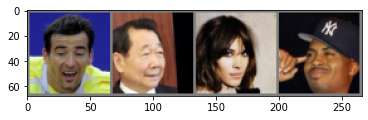

In [7]:
data_loader_sample = torch.utils.data.DataLoader(dataset=dataset, 
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(data_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

### Utils 
* Use the below code for the convolutions or the upconvolutions

In [8]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
    
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

### 2.1 Write the code (Generator) [4 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [9]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
#논문과 다르게 stride를 4를 쓴다.
cfg_g = [[z_size,gfc*8,4,1,0,'ReLU'], [gfc*8,gfc*4,4,2,1,'ReLU'], [gfc*4,gfc*2,4,2,1,'ReLU'], [gfc*2,gfc,4,2,1,'ReLU'], [gfc,3,4,2,1,'Tanh']]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        #############
        #layer를 쌓아준다.
        self.generator=nn.Sequential(
        upconv2d(cfg_g[0]),
        upconv2d(cfg_g[1]),
        upconv2d(cfg_g[2]),
        upconv2d(cfg_g[3]),
        upconv2d(cfg_g[4],False))
        #############
        
    def forward(self, x):
        
        #############
        return self.generator(x)
        #############
        

STEP 3-1: CREATE MODEL CLASS (Generator)


### 2.2 Write the code (Discriminator) [4 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [10]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
cfg_d = [[3,dfc,4,2,1,'LeakyReLU'], [dfc,2*dfc,4,2,1,'LeakyReLU'], [2*dfc,4*dfc,4,2,1,'LeakyReLU'], [4*dfc,8*dfc,4,2,1,'LeakyReLU'], [8*dfc,1,4,1,0,'Sigmoid']]


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #############
        #앞선 generator의 layer를 거꾸로 수행한다.
        self.discriminator=nn.Sequential(
        conv2d(cfg_d[0]),
        conv2d(cfg_d[1]),
        conv2d(cfg_d[2]),
        conv2d(cfg_d[3]),
        conv2d(cfg_d[4],False))
        #############
        
    def forward(self, x):
        
        #############
        return self.discriminator(x)
        #############
        

STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G = Generator()
model_D = Discriminator()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G.to(device)
print(model_G)
model_D.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1,

In [12]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.BCELoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the DCGAN [2 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
[0/5][400/1582]	Loss_D: 1.7662	Loss_G: 3.6890	
[0/5][800/1582]	Loss_D: 0.3532	Loss_G: 6.4163	
[0/5][1200/1582]	Loss_D: 0.7318	Loss_G: 2.8523	
[1/5][400/1582]	Loss_D: 0.4231	Loss_G: 6.3827	
[1/5][800/1582]	Loss_D: 0.2331	Loss_G: 3.4525	
[1/5][1200/1582]	Loss_D: 0.4393	Loss_G: 2.7080	
[2/5][400/1582]	Loss_D: 0.4887	Loss_G: 1.9083	
[2/5][800/1582]	Loss_D: 0.4243	Loss_G: 2.4665	
[2/5][1200/1582]	Loss_D: 0.3414	Loss_G: 3.1281	
[3/5][400/1582]	Loss_D: 0.2858	Loss_G: 3.9409	
[3/5][800/1582]	Loss_D: 0.5820	Loss_G: 5.5070	
[3/5][1200/1582]	Loss_D: 0.3587	Loss_G: 2.1481	
[4/5][400/1582]	Loss_D: 0.6607	Loss_G: 2.6367	
[4/5][800/1582]	Loss_D: 0.3575	Loss_G: 3.3491	
[4/5][1200/1582]	Loss_D: 0.2649	Loss_G: 3.9854	


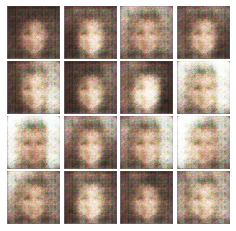

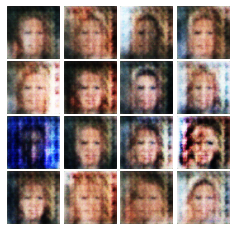

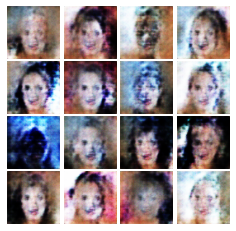

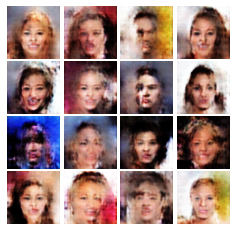

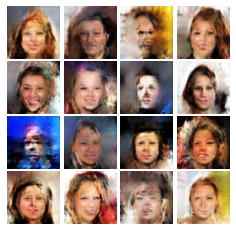

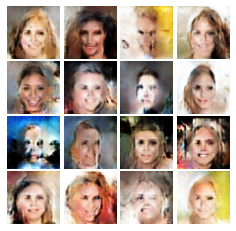

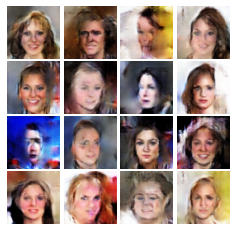

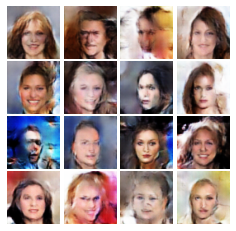

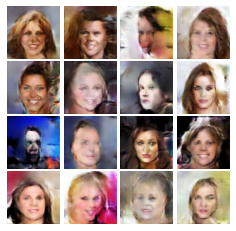

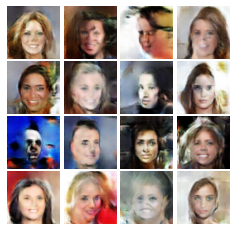

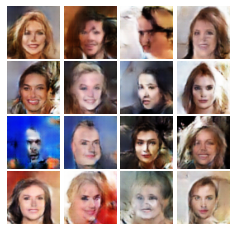

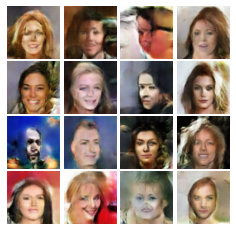

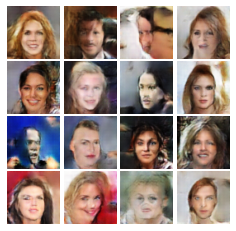

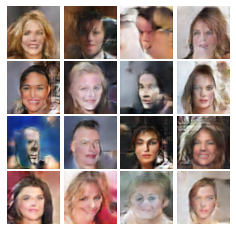

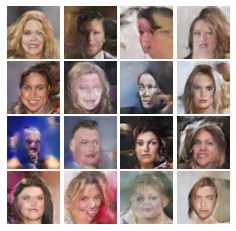

In [13]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3), cmap='Greys_r')
    return fig

print('STEP 7: TRAIN THE MODEL')

label_real = torch.full((bs,), real_label, device=device, dtype=torch.float)
label_fake = torch.full((bs,), fake_label, device=device, dtype=torch.float)

#  The input noise for inference
fixed_noise = torch.randn(bs, z_size, 1, 1, device=device, dtype=torch.float)


for epoch in range(num_epochs):
    
    model_G.train()
    model_D.train()
    
    for i, data in enumerate(data_loader):
        
        data = data[0].to(device)
        
        ### Update discriminator model
        
        # Clear gradients w.r.t. parameters
        model_D.zero_grad()
        
        # Forward pass to get results of discriminator for real data
        output_D_real = model_D(data).view(-1)
        
        # Calculate Loss
        err_D_real = criterion(output_D_real, label_real)
        
        # Generating noise inputs for generating fake samples
        noise = torch.randn(bs, z_size, 1, 1, device=device)
        
        # Forward pass to get generated samples
        output_G = model_G(noise)
        
        # Forward pass to get results of discriminator for fake data
        output_D_fake = model_D(output_G.detach()).view(-1)
        
        # Calculate Loss
        err_D_fake = criterion(output_D_fake, label_fake)
        
        # Combine the losses for real data and fake data
        err_D = err_D_real + err_D_fake
        
        # Getting gradients w.r.t. parameters
        err_D.backward()
        
        # Updating parameters
        optimizer_D.step()
        
        
        ### Update generator model
        
        # Clear gradients w.r.t. parameters
        model_G.zero_grad()
        
        # Forward pass to get results of discriminator for fake data
        output_G_real = model_D(output_G).view(-1)
        
        # Calculate Loss
        err_G = criterion(output_G_real, label_real)
        
        # Getting gradients w.r.t. parameters
        err_G.backward()
        
        # Updating parameters
        optimizer_G.step()
        
        # Output training stats
        if i % 400 == 0 and i != 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(data_loader),
                     err_D.item(), err_G.item()))

            model_G.eval()
            model_D.eval()
            with torch.no_grad():
                output = model_G(fixed_noise).detach().cpu().numpy()
                output = np.transpose((output+1)/2, (0, 2, 3, 1))
                fig = plot(output[:16])
                
            model_G.train()
            model_D.train()
         

### *References*
[1] Radford et al., "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial network", *ICLR*, 2016. <br>
[2] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010 <br>

### *Discussion*

이번에는 Deep Convolutional Generative Adversarial Network를 구현했다. GAN 논문만 읽었기 때문에 DCGAN에 대해 추가적인 공부를 해주었다. DCGAN은 GAN에 CNN을 사용하여 이미지를 생성한다. 기존의 GAN에 비해서 더 안정적인 학습과 더 좋은 이미지 품질을 제공한다. generator는 noise를 transposed convolution을 통해 이미지 size까지 size를 키우고 discriminator는 generator model의 reverse 버전이다. convolution을 통해 size를 줄인다.

구현은 상당히 쉬웠는데 이미 상당 부분 구현이 되어있고 layer만 쌓으면 됐기 때문이다. 모델의 구조 자체도 굉장히 단순한 구조이다. 결과를 살펴보면, train이 될수록 점점 사람의 모습으로 바뀌는 것을 볼 수 있으나 자세히 보면 온전하지 못한 것을 볼 수 있다. 현재는 많은 연구로 인해 훨씬 사람과 비슷한 데이터를 생성할 수 있다.